In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import nibabel as nib
from glob import glob
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [5]:
train_df = pd.read_csv("train.csv")
train_bbox = pd.read_csv("train_bounding_boxes.csv")
test_df = pd.read_csv("test.csv")
ss = pd.read_csv("sample_submission.csv")

# Print dataframe shapes
print('train shape:', train_df.shape)
print('train bbox shape:', train_bbox.shape)
print('test shape:', test_df.shape)
print('ss shape:', ss.shape)
print('')

# Show first few entries
train_df.head(3)

train shape: (2019, 9)
train bbox shape: (7217, 6)
test shape: (3, 3)
ss shape: (3, 2)



,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0


In [6]:
test_df.head(3)

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [7]:
train_bbox.head(3)

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135


(0.0, 2800.0)

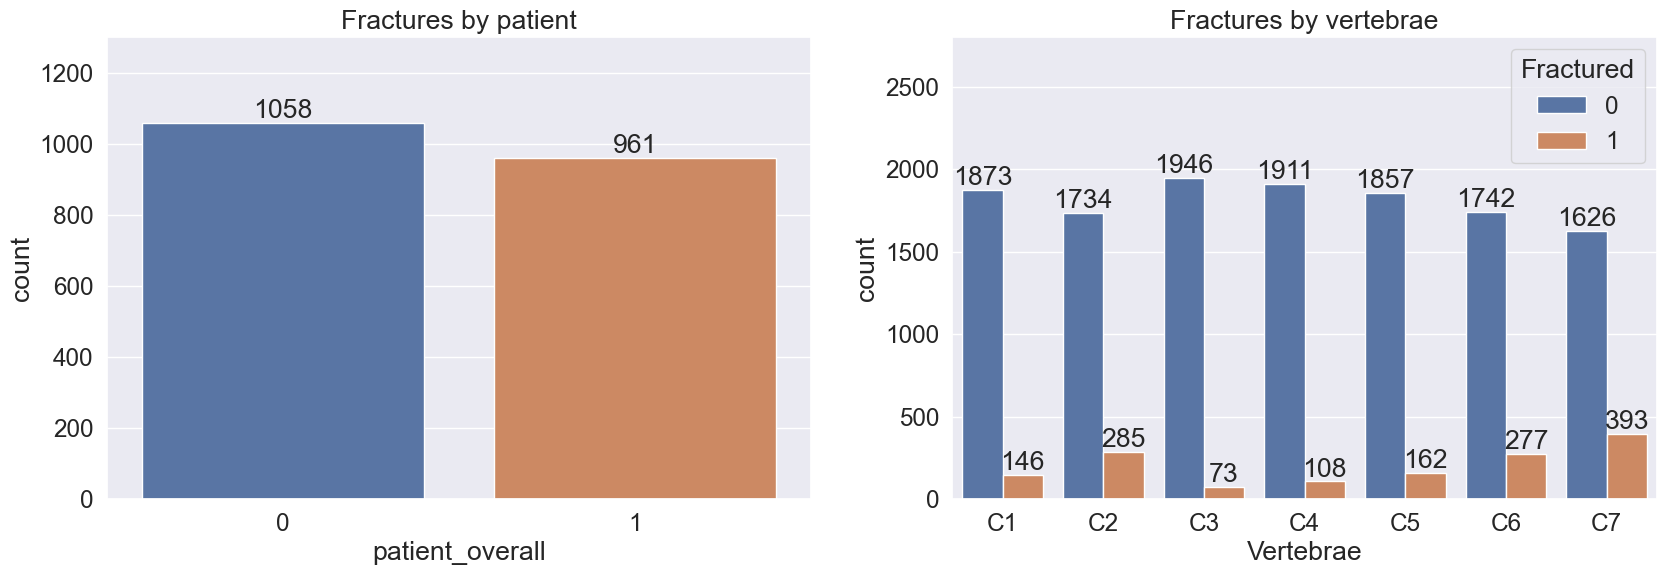

In [8]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=train_df, x='patient_overall')
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures by patient')
plt.ylim([0,1300])
# Unpivot train_df for plotting
train_melt = pd.melt(train_df, id_vars = ['StudyInstanceUID', 'patient_overall'],
             value_vars = ['C1','C2','C3','C4','C5','C6','C7'],
             var_name="Vertebrae",
             value_name="Fractured")
plt.subplot(1,2,2)
ax2 = sns.countplot(data=train_melt, x='Vertebrae', hue='Fractured')
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures by vertebrae')
plt.ylim([0,2800])

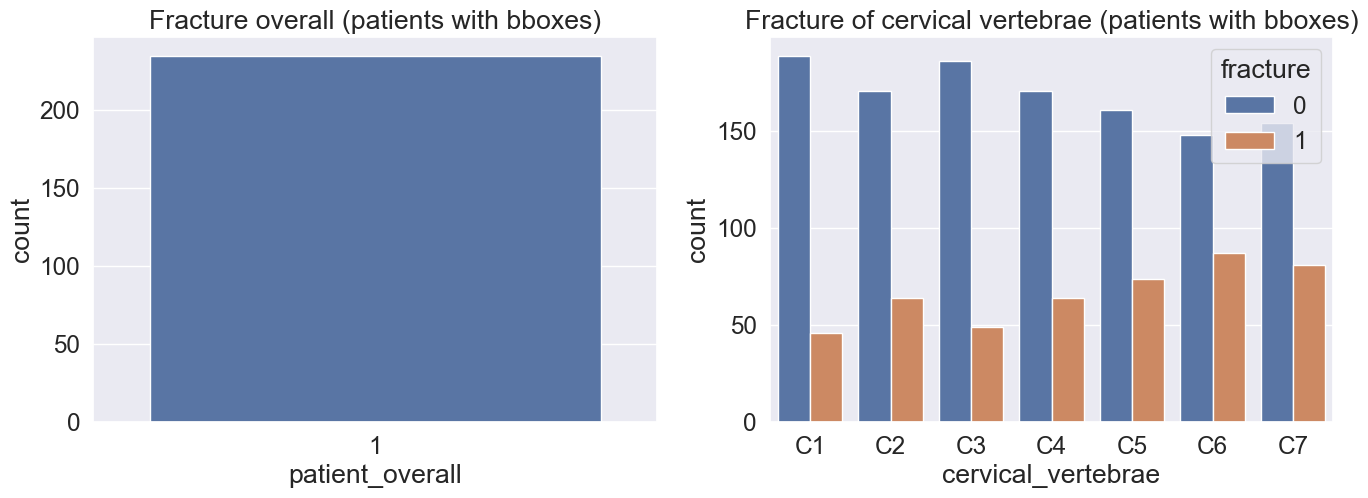

In [9]:
train_df_bbox = train_df[train_df["StudyInstanceUID"].isin(train_bbox["StudyInstanceUID"])]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(x="patient_overall", data=train_df_bbox, ax=ax1)
ax1.set_title("Fracture overall (patients with bboxes)")
train_df_bbox_melt = pd.melt(train_df_bbox, id_vars=["StudyInstanceUID", "patient_overall"], var_name="cervical_vertebrae", value_name="fracture")
sns.countplot(x="cervical_vertebrae", hue="fracture", data=train_df_bbox_melt, ax=ax2)
ax2.set_title("Fracture of cervical vertebrae (patients with bboxes)")
plt.show()

In [10]:
base_path = "C:/Users/guruC/OneDrive/Desktop/python"
seg_paths = glob(f"{base_path}/segmentations/*")
seg_df = pd.DataFrame({'path': seg_paths})
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('/')[-1][:-4])
seg_df = seg_df[['StudyInstanceUID','path']]
print('seg_df shape:', seg_df.shape)

seg_df shape: (0, 2)


In [11]:
meta_train = pd.read_csv("meta_train_clean.csv")
# Only select patients with segmentations
meta_seg = meta_train[meta_train['StudyInstanceUID'].isin(seg_df['StudyInstanceUID'])].reset_index(drop=True)
print('meta_seg shape:', meta_seg.shape)

meta_seg shape: (0, 8)


In [12]:
ex_path = "segmentations/1.2.826.0.1.3680043.11827.nii"
example = nib.load(ex_path)
example = example.get_fdata()  # convert to numpy array
example = example[:, ::-1, ::-1].transpose(2, 1, 0)  # align orientation with train image
np.unique(example[119])

array([0., 4., 5.])

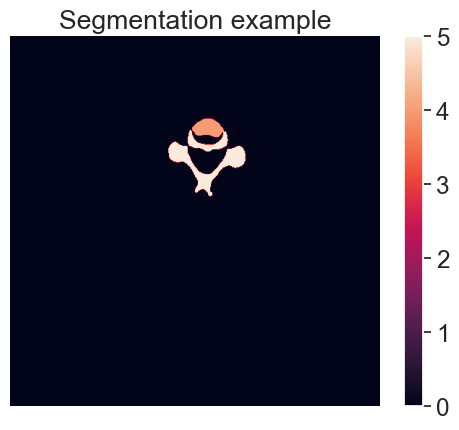

In [13]:
plt.figure()
plt.imshow(example[119])
plt.title('Segmentation example')
plt.colorbar()
plt.axis('off')
plt.show()

In [14]:
targets = ['C1','C2','C3','C4','C5','C6','C7']
meta_seg[targets]=0

In [15]:
meta_seg = pd.read_csv('meta_segmentation.csv')
meta_seg.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10633,1,512,512,1.0,-68.0,98.0,314.099976,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10633,2,512,512,1.0,-68.0,98.0,313.599976,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10633,3,512,512,1.0,-68.0,98.0,313.099976,0,0,0,0,0,0,0


In [16]:
# Example
meta_seg[['StudyInstanceUID','Slice']+targets].iloc[199:204,:]

,StudyInstanceUID,Slice,C1,C2,C3,C4,C5,C6,C7
199,1.2.826.0.1.3680043.10633,200,0,1,1,0,0,0,0
200,1.2.826.0.1.3680043.10633,201,0,1,1,0,0,0,0
201,1.2.826.0.1.3680043.10633,202,0,0,1,1,0,0,0
202,1.2.826.0.1.3680043.10633,203,0,0,1,1,0,0,0
203,1.2.826.0.1.3680043.10633,204,0,0,1,1,0,0,0


In [17]:
# Print example of extracted vertebrae
print('UID:', meta_seg['StudyInstanceUID'].unique()[0])
pd.set_option('display.max_rows', 50)
meta_seg[meta_seg['StudyInstanceUID']==meta_seg['StudyInstanceUID'].unique()[0]].loc[110:340,targets]

UID: 1.2.826.0.1.3680043.10633


,C1,C2,C3,C4,C5,C6,C7
110,0,0,0,0,0,0,0
111,1,0,0,0,0,0,0
112,1,0,0,0,0,0,0
113,1,0,0,0,0,0,0
114,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
336,0,0,0,0,0,0,0
337,0,0,0,0,0,0,0
338,0,0,0,0,0,0,0
339,0,0,0,0,0,0,0


In [18]:
# Calculate slice ratio (to generalise better)
slice_max_seg = meta_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_seg['SliceRatio'] = 0
meta_seg['SliceRatio'] = meta_seg['Slice']/meta_seg['StudyInstanceUID'].map(slice_max_seg)

In [19]:
features = ['SliceRatio','SliceThickness','ImagePositionPatient_x','ImagePositionPatient_y','ImagePositionPatient_z']

# Features and targets
X = meta_seg[['StudyInstanceUID']+features]
y = meta_seg[targets]

In [20]:
# Train-valid split, grouped by patient (80/20 split)
gkf = GroupKFold(n_splits=5)
(train_idx, valid_idx) = next(gkf.split(X, y, groups = X['StudyInstanceUID']))

# Train set
X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx,:]

# Validation set
X_valid, y_valid = X.iloc[valid_idx,:], y.iloc[valid_idx,:]

# Drop patient id
X_train = X_train.drop('StudyInstanceUID', axis=1)
X_valid = X_valid.drop('StudyInstanceUID', axis=1)

In [21]:
# Train classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [22]:
# Train classifier
cle = DecisionTreeClassifier()
cle.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
# Train classifier
clg = XGBClassifier()
clg.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [24]:
# Feature importances
pd.DataFrame({'Feature':features,'Importance':clf.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,SliceRatio,0.572563
4,ImagePositionPatient_z,0.214658
3,ImagePositionPatient_y,0.090357
2,ImagePositionPatient_x,0.088703
1,SliceThickness,0.033719


In [25]:
# Feature importances
pd.DataFrame({'Feature':features, 'Importance':cle.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,SliceRatio,0.548097
4,ImagePositionPatient_z,0.176228
2,ImagePositionPatient_x,0.112568
3,ImagePositionPatient_y,0.096048
1,SliceThickness,0.067058


In [26]:
# Feature importances
pd.DataFrame({'Feature':features, 'Importance':clg.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature,Importance
0,SliceRatio,0.388281
1,SliceThickness,0.311267
2,ImagePositionPatient_x,0.110056
3,ImagePositionPatient_y,0.104815
4,ImagePositionPatient_z,0.085581


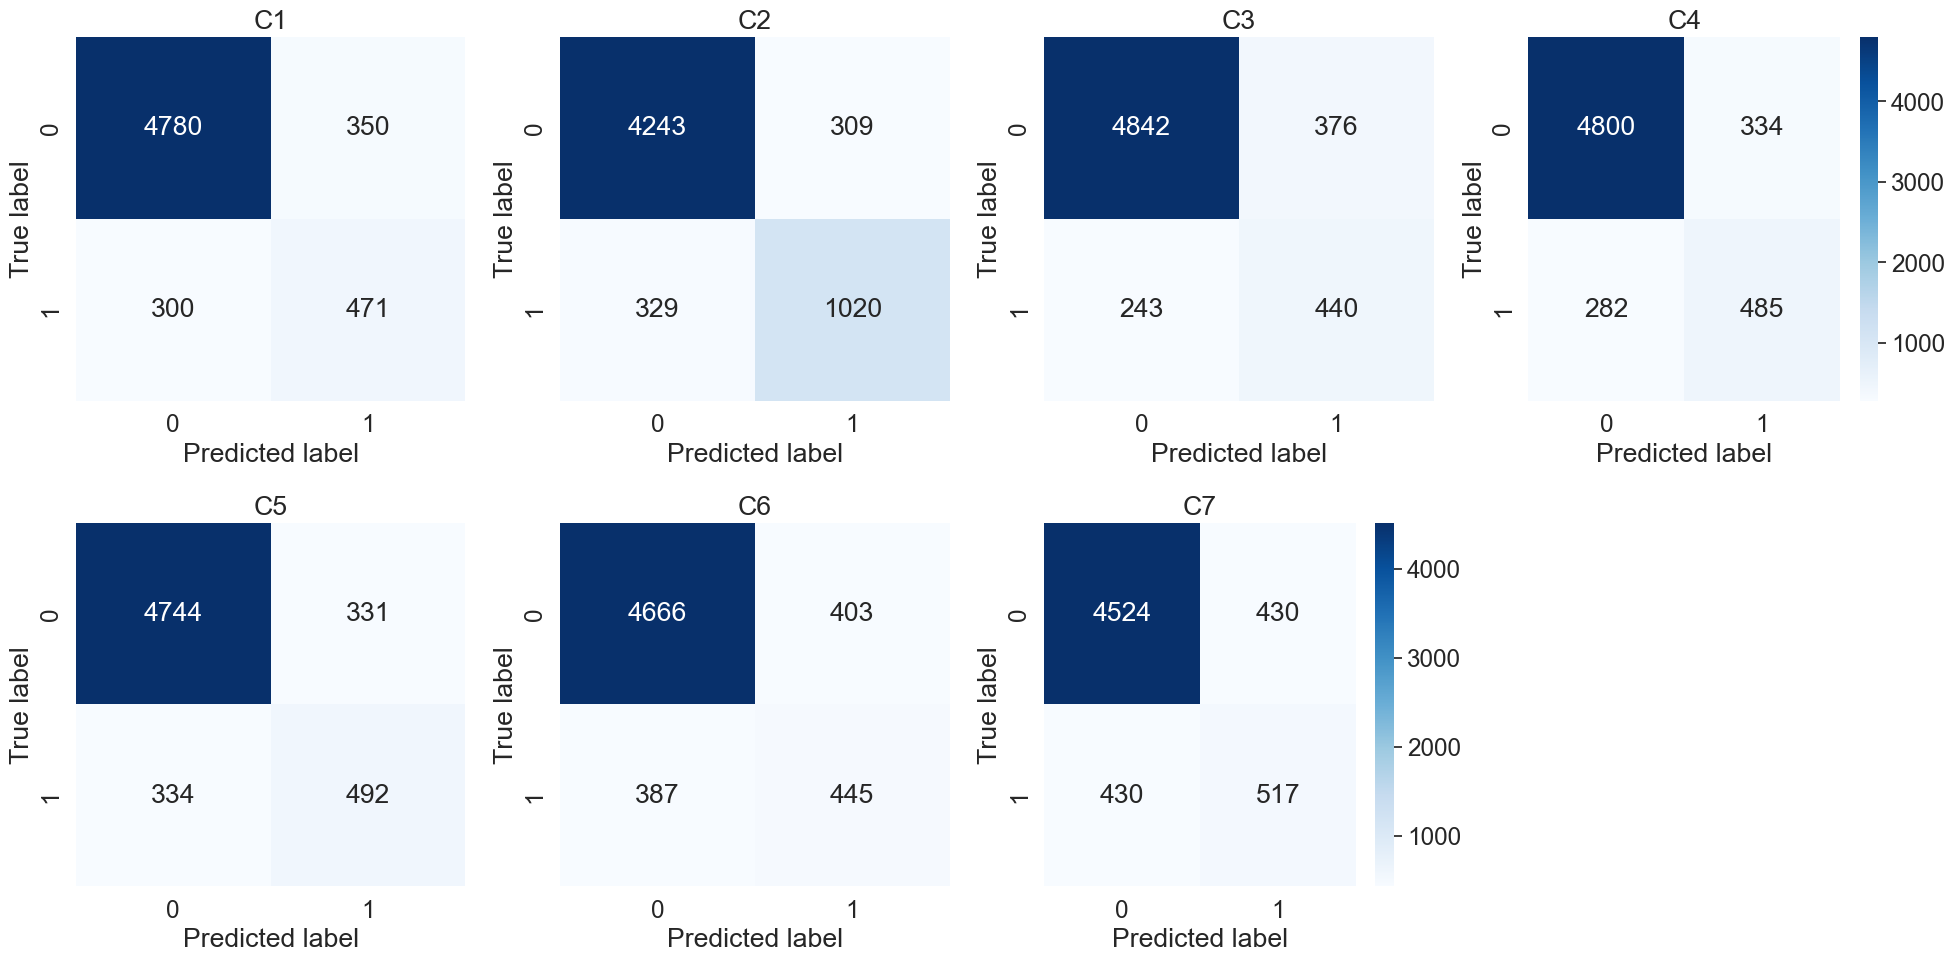

In [27]:
preds = clf.predict(X_valid)
# Confusion matrices
fig = plt.figure(figsize=(20,10))
for i in range(7):
    cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
    plt.subplot(2,4,i+1)
    CBAR=False
    if (i==3) or (i==6):
        CBAR=True
    sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'C{i+1}')
fig.tight_layout()

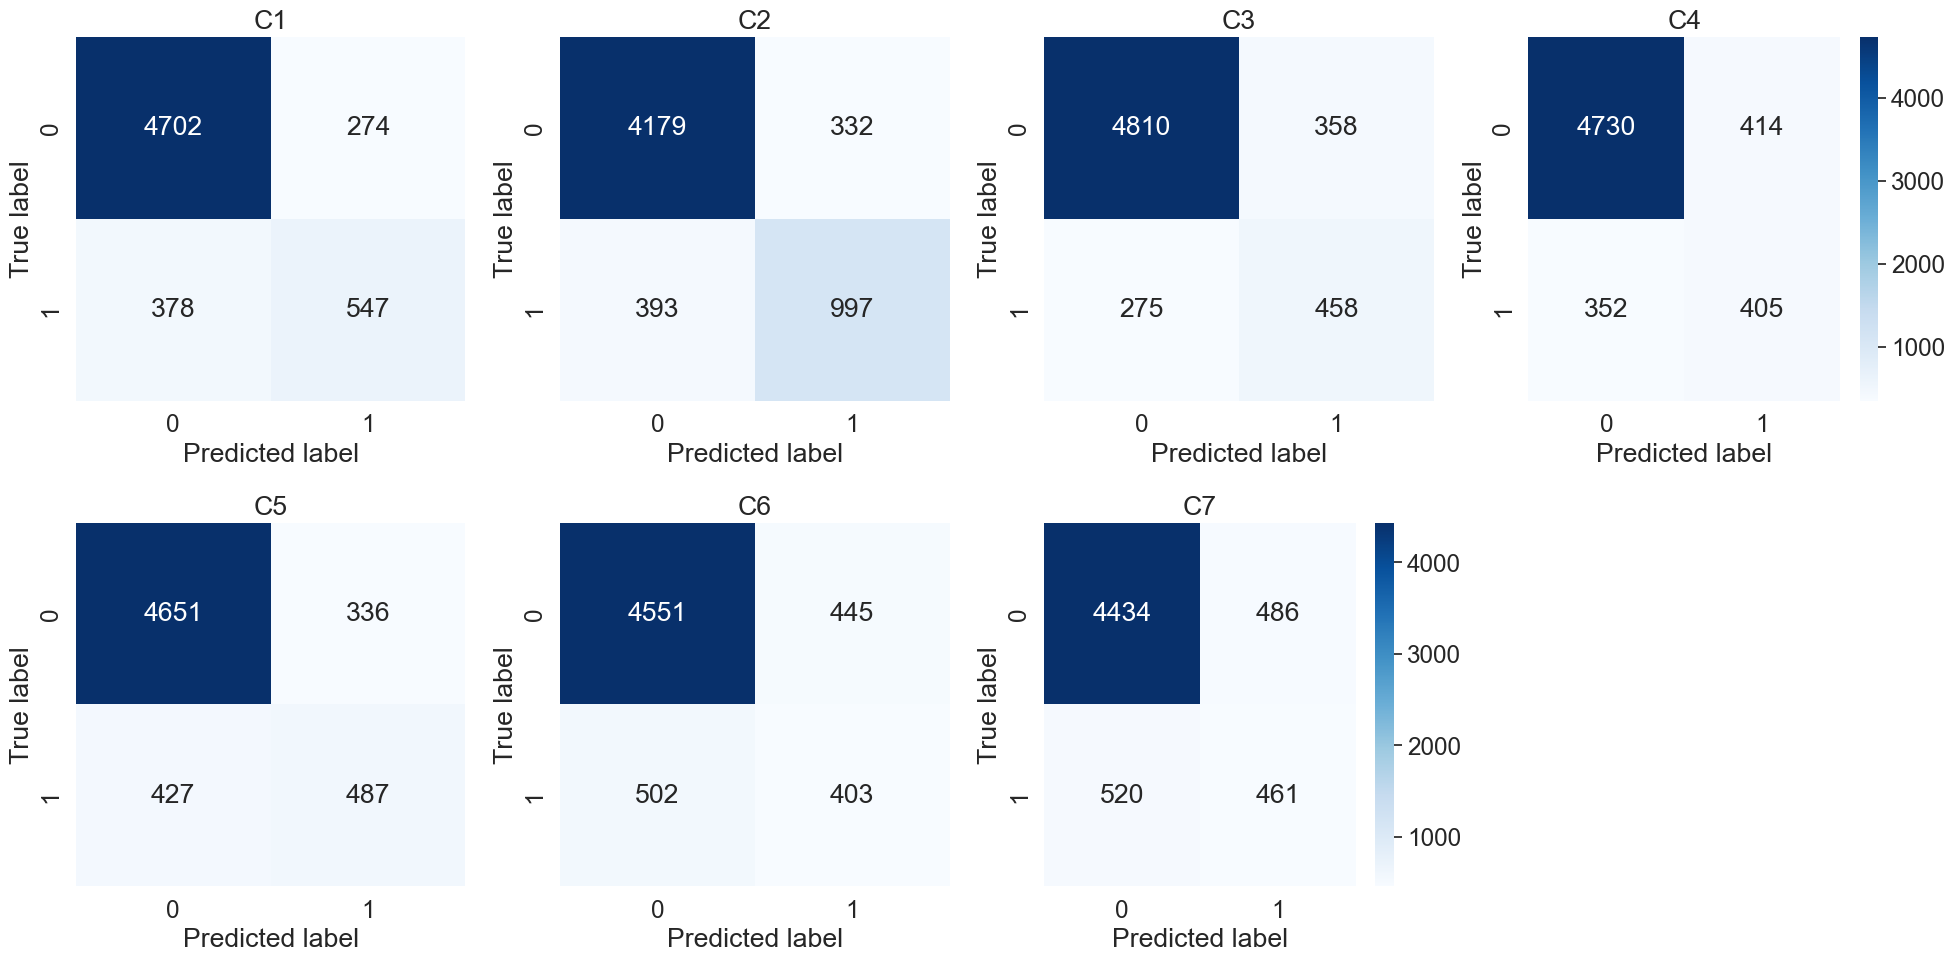

In [28]:
preds = cle.predict(X_valid)

# Confusion matrices
fig = plt.figure(figsize=(20,10))
for i in range(7):
    cm = confusion_matrix(preds[:,i], y_valid.values[:,i])
    plt.subplot(2,4,i+1)
    CBAR=False
    if (i==3) or (i==6):
        CBAR=True
    sns.heatmap(cm, annot=True, fmt='d', cbar=CBAR, cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'C{i+1}')
fig.tight_layout()

In [29]:
np.set_printoptions(threshold=np.inf)
clf.predict(X.drop('StudyInstanceUID',axis=1))[110:250,:]

array([[1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1,

In [30]:
np.set_printoptions(threshold=np.inf)
cle.predict(X.drop('StudyInstanceUID',axis=1))[110:250,:]

array([[1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1,

In [31]:
# Read in metadata for entire train set
meta_train = pd.read_csv('meta_train_clean.csv')

# Calculate slice ratio (to generalise better)
slice_max_train = meta_train.groupby('StudyInstanceUID')['Slice'].max().to_dict()
meta_train['SliceRatio'] = 0
meta_train['SliceRatio'] = meta_train['Slice']/meta_train['StudyInstanceUID'].map(slice_max_train)

# Initialise targets
meta_train[targets]=0

# Predict targets for entire train set
meta_train[targets] = clf.predict(meta_train[features])

# We know images with segmentations have 100% accurate targets so put these back in
meta_train.loc[meta_train['StudyInstanceUID'].isin(meta_seg['StudyInstanceUID']),targets] = meta_seg[targets].values

# Save to csv
meta_train.to_csv('meta_train_with_vertebrae.csv', index=False)

# Preview
meta_train.head(3)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,SliceRatio,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,1,512,512,0.625,-52.308,-27.712,7.282,0.003731,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10001,2,512,512,0.625,-52.308,-27.712,6.657,0.007463,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10001,3,512,512,0.625,-52.308,-27.712,6.032,0.011194,0,0,0,0,0,0,0


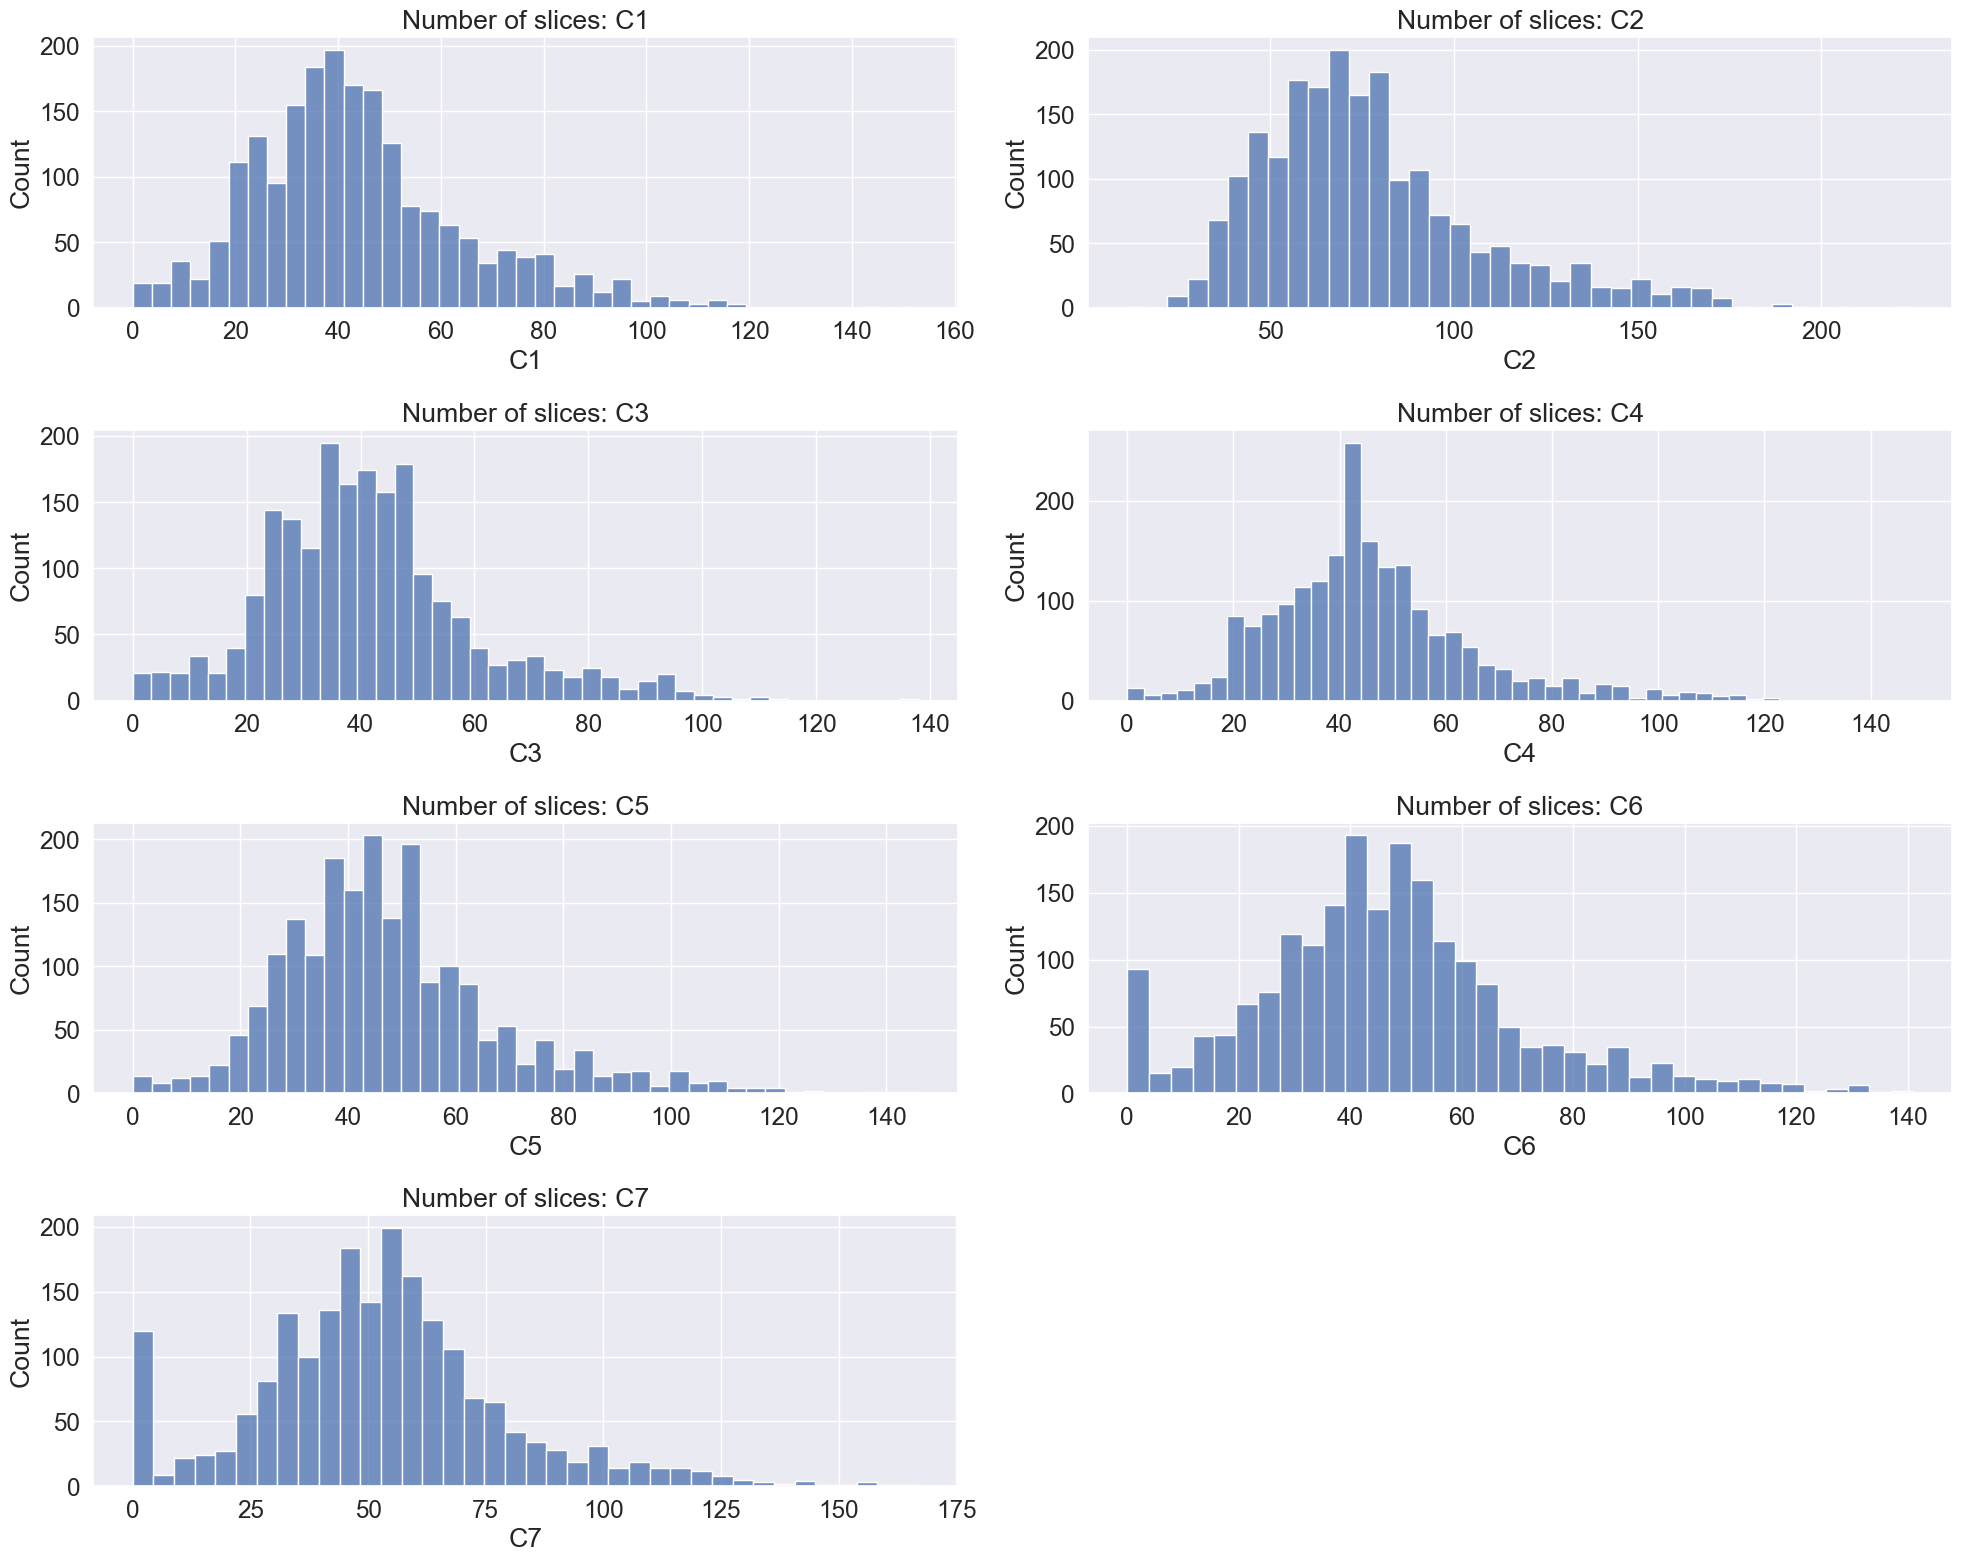

In [32]:
fig = plt.figure(figsize=(20,16))
for i, Cx in enumerate(targets):
    plt.subplot(4,2,i+1)
    sns.histplot(meta_train.groupby('StudyInstanceUID')[Cx].sum())
    plt.title(f'Number of slices: {Cx}')
fig.tight_layout()

In [33]:
# Evaluate model
y_preds = clf.predict(X_valid)
total_acc1 = 0 
for i in range(7):
    acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    total_acc1+=acc/7
    print(f'Accuracy of C{i+1}: {acc} %')

print('')
print(f'Overall accuracy: {total_acc1} %')

Accuracy of C1: 0.8898491781054059 %
Accuracy of C2: 0.891882731740383 %
Accuracy of C3: 0.8951025249957635 %
Accuracy of C4: 0.8956109134045077 %
Accuracy of C5: 0.8873072360616845 %
Accuracy of C6: 0.8661243856973394 %
Accuracy of C7: 0.8542619894933062 %

Overall accuracy: 0.8828769942140557 %


In [34]:
# Evaluate model
y_preds = cle.predict(X_valid)
total_acc2 = 0 
for i in range(7):
    acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    total_acc2+=acc/7
    print(f'Accuracy of C{i+1}: {acc} %')
print('')
print(f'Overall accuracy: {total_acc2} %')

Accuracy of C1: 0.8895102524995764 %
Accuracy of C2: 0.8771394678867989 %
Accuracy of C3: 0.8927300457549567 %
Accuracy of C4: 0.8701914929672937 %
Accuracy of C5: 0.8706998813760379 %
Accuracy of C6: 0.8395187256397221 %
Accuracy of C7: 0.8295204202677512 %

Overall accuracy: 0.867044326627448 %


In [35]:
# Evaluate model
y_preds = clg.predict(X_valid)
total_acc3 = 0 
for i in range(7):
    acc = (y_valid[f'C{i+1}']==y_preds[:,i]).sum()/len(y_preds[:,i])
    total_acc3+=acc/7
    print(f'Accuracy of C{i+1}: {acc} %')

print('')
print(f'Overall accuracy: {total_acc3} %')

Accuracy of C1: 0.8912048805287239 %
Accuracy of C2: 0.8922216573462125 %
Accuracy of C3: 0.9013726487036096 %
Accuracy of C4: 0.8839179800033893 %
Accuracy of C5: 0.8773089306897136 %
Accuracy of C6: 0.8666327741060837 %
Accuracy of C7: 0.8542619894933062 %

Overall accuracy: 0.8809886944101483 %


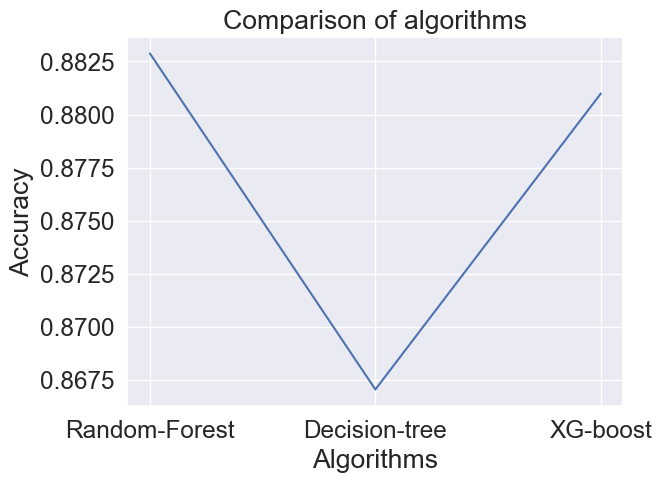

In [36]:
x = [total_acc1, total_acc2, total_acc3]
y = ['Random-Forest', 'Decision-tree', 'XG-boost']
plt.plot(y, x)
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Comparison of algorithms')
plt.show()